In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large
import numpy as np

In [2]:
def load_json_metrics(file_path):
    with open(file_path, 'r') as fp:
        metrics = json.load(fp)
    return metrics

def plot_json(json_dict, name, ax):
    ax.plot(list(json_dict.keys()), list(json_dict.values()), label=name)
    
def get_mean_metric(metric_dict, from_epoch, to_epoch=None):
    df = pd.DataFrame.from_dict(metric_dict, orient='index')
    return df[from_epoch:to_epoch].mean().item()

def get_n_params(model, verbose=False):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print('Total Params: ', pytorch_total_params)

    params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            params += param.numel()
    if verbose:
        print('Trainable Params: ', params)
    return pytorch_total_params, params

### IoU Metrics

In [7]:
metric_of_interest = 'acc'

# UNet
unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_per_class/frosty_sponge_239_unet_ice-mean-{metric_of_interest}-epoch.json')

# Small UNet
# small_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/laced_disco_238_small_unet_ice-mean-{metric_of_interest}-epoch.json')

# LBC UNet
# lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/worthy_wood_227_lbc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small LBC UNet
# small_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/sandy_moon_228_small_lbc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Deeplab MobileNet
# deeplab_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/vivid_donkey_305_deeplab_mobilenet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# LRASPP MobileNet
lraspp_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_per_class/clean_darkness_312_laraspp_mobilenet_ice-mean-{metric_of_interest}-epoch.json')

# DSC UNet
# dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/helpful_fire_308_unet_dsc_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small DSC UNet
# small_dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/cosmic_waterfall_315_small_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# DSC LBC UNet
# dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/youthful_microwave_310_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small DSC LBC UNet
# small_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/still_paper_311_small_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Skinny DSC LBC UNet
skinny_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_per_class/clear_lake_355_skinny_small_dsc_lbc_unet-mean-{metric_of_interest}-epoch.json')


metric_dicts = {
    'unet': unet, 
#     'small_unet': small_unet,
#     'lbc_unet': lbc_unet, 
#     'small_lbc_unet': small_lbc_unet,
#     'deeplab_mobile_net': deeplab_mobile_net,
    'lraspp_mobile_net': lraspp_mobile_net,
#     'dsc_unet': dsc_unet,
#     'small_dsc_unet': small_dsc_unet,
#     'dsc_lbc_unet': dsc_lbc_unet,
#     'small_dsc_lbc_unet': small_dsc_lbc_unet,
}

NameError: name 'lbc_unet' is not defined

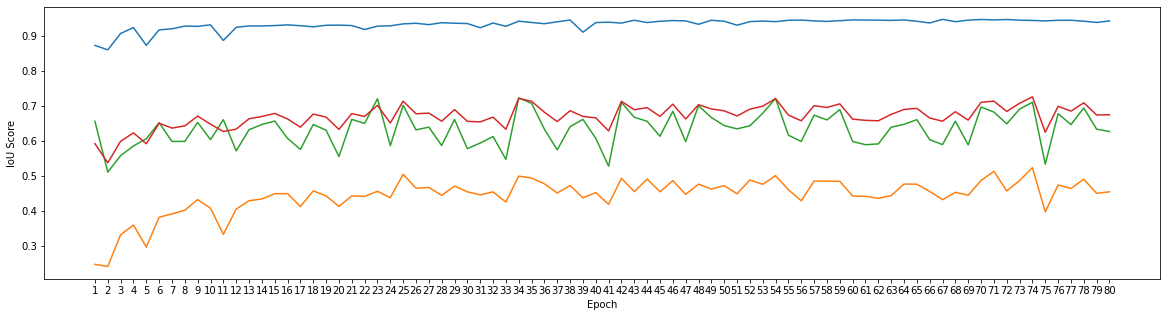

In [42]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_ylabel('IoU Score')
ax.set_xlabel('Epoch')
plot_json(unet, 'unet', ax)
plot_json(lbc_unet, 'lbc_unet', ax)
plot_json(deeplab_mobile_net, 'deeplab_mobile_net', ax)
plot_json(lraspp_mobile_net, 'lraspp_mobile_net', ax)
plot_json(dsc_unet, 'dsc_unet', ax)
plot_json(small_dsc_unet, 'small_dsc_unet', ax)
plot_json(dsc_lbc_unet, 'dsc_lbc_unet', ax)
plot_json(small_dsc_lbc_unet, 'small_dsc_lbc_unet', ax)
plt.legend();
# ax.set_title('Full Size Comparison');

In [10]:
print(unet['32'], 67.7)
print(lraspp_mobile_net['18'], 63.7)
print(skinny_dsc_lbc_unet['40'], 68.9)

[0.9830930233001709, 0.849152147769928, 0.6301117539405823, 0.8207855820655823] 67.7
[0.9617713689804077, 0.746016263961792, 0.6142646670341492, 0.7740173935890198] 63.7
[0.9771385192871094, 0.8376074433326721, 0.7028360962867737, 0.8391939997673035] 68.9


In [77]:
np.mean([0.937, 0.464, 0.613])

0.6713333333333334

In [72]:
[x[-1] for x in skinny_dsc_lbc_unet.values()][42]

0.6968548893928528

In [68]:
max([x[-1] for x in skinny_dsc_lbc_unet.values()])

0.7318708896636963

In [67]:
[x[-1] for x in lraspp_mobile_net.values()]

[0.4493391513824463,
 0.5657999515533447,
 0.538835883140564,
 0.5910844206809998,
 0.5837132930755615,
 0.6055654883384705,
 0.6025266051292419,
 0.5991683006286621,
 0.5986459255218506,
 0.6187359690666199,
 0.6133162975311279,
 0.6169670224189758,
 0.6255543231964111,
 0.6243613958358765,
 0.6168658137321472,
 0.6221177577972412,
 0.6140215396881104,
 0.6219912171363831,
 0.619109570980072,
 0.6306048631668091,
 0.6311715245246887,
 0.6114827990531921,
 0.6142190098762512,
 0.620600163936615,
 0.6238939166069031,
 0.6331101059913635,
 0.6161940693855286,
 0.6233603358268738,
 0.636742353439331,
 0.6351091861724854,
 0.6215689778327942,
 0.6380720734596252,
 0.636210024356842,
 0.6391356587409973,
 0.6179130673408508,
 0.6194387674331665,
 0.6279118657112122,
 0.630099356174469,
 0.625115156173706,
 0.6375579237937927,
 0.6377220749855042,
 0.6316127181053162,
 0.6276621222496033,
 0.6450011730194092,
 0.6414832472801208,
 0.6394734382629395,
 0.63212651014328,
 0.6177683472633362,
 

In [40]:
print(unet['32'], 67.7)
print(lraspp_mobile_net['18'], 63.7)
print(skinny_dsc_lbc_unet['40'], 68.9)

[0.9377267360687256, 0.4549425542354584, 0.6132637858390808, 0.668644368648529]
[0.905290961265564, 0.41642534732818604, 0.6180418729782104, 0.6465860605239868]
[0.945196270942688, 0.4832383096218109, 0.670803427696228, 0.6997459530830383]


In [32]:
FROM_EPOCH = 20
avg_metric_dict = {}
for model in metric_dicts.keys():
    avg_metric_dict[model] = get_mean_metric(metric_dicts[model], FROM_EPOCH)

In [33]:
avg_metric_dict

{'unet': 0.682293904821078,
 'small_unet': 0.7044796794652939,
 'lbc_unet': 0.6352974305550257,
 'small_lbc_unet': 0.6416343748569489,
 'deeplab_mobile_net': 0.6175214439630509,
 'lraspp_mobile_net': 0.6361964911222457,
 'dsc_unet': 0.6831983198722203,
 'small_dsc_unet': 0.6951989223559697,
 'dsc_lbc_unet': 0.6656334926684697,
 'small_dsc_lbc_unet': 0.677533096075058}

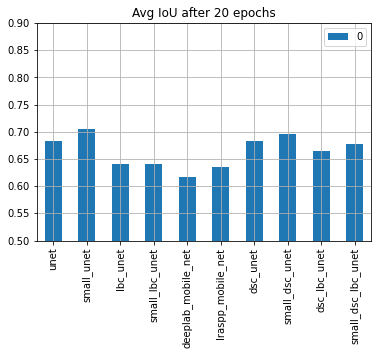

In [21]:
ax = pd.DataFrame.from_dict(avg_metric_dict, orient='index').plot.bar(ylim=(0.5, 0.90), title='Avg IoU after 20 epochs')
ax.grid();

In [ ]:
pd.DataFrame.from_dict(avg_metric_dict, orient='index')

### Model Parameters

In [4]:
unet_model = UNet(n_channels=3, n_classes=3, bilinear=True)
small_unet_model = SmallUNet(n_channels=3, n_classes=3, bilinear=True)
# axial_unet_model = AxialUNet(3, 3, 64)
lbc_unet_model = UNetLBP(3, 3)
small_lbc_unet_model = SmallUNetLBP(3, 3)
small_axial_lbc_unet_model = SmallAxialUNetLBC(3, 3, 10)
deeplab_mobile_net_model = deeplabv3_mobilenet_v3_large(num_classes=3)
lraspp_mobile_net_model = lraspp_mobilenet_v3_large(num_classes=3)
dsc_unet_model = UNetDSC(n_channels=3, n_classes=3, bilinear=True)
small_dsc_unet_model = SmallUNetDSC(n_channels=3, n_classes=3, bilinear=True)
dsc_lbc_unet_model = DSCUNetLBP(3, 3)
# small_dsc_lbc_unet_model = DSCSmallUNetLBP(3, 3)

models_dict = {
    'unet': unet_model,
#     'axial_unet': axial_unet_model,
    'small_unet': small_unet_model,
    'lbc_unet': lbc_unet_model,
    'small_lbc_unet': small_lbc_unet_model,
    'small_axial_lbc_unet': small_axial_lbc_unet_model,
    'deeplab_mobile_net': deeplab_mobile_net_model,
    'lraspp_mobile_net': lraspp_mobile_net_model,
    'dsc_unet': dsc_unet_model,
    'small_dsc_unet': small_dsc_unet_model,
    'dsc_lbc_unet': dsc_lbc_unet_model,
#     'small_dsc_lbc_unet': small_dsc_lbc_unet_model,
}

In [5]:
model_tot_param_dict, model_train_param_dict = {}, {}
for model in models_dict.keys():
#     print(model, ': ')
    tot, train = get_n_params(models_dict[model])
    model_tot_param_dict[model] = tot
    model_train_param_dict[model] = train

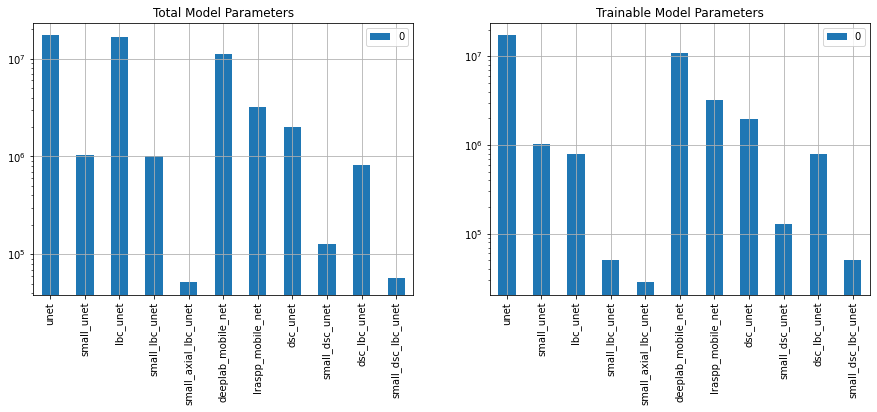

In [6]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(model_tot_param_dict, orient='index').plot.bar(ax=axs[0], title='Total Model Parameters', logy=True)
pd.DataFrame.from_dict(model_train_param_dict, orient='index').plot.bar(ax=axs[1], title='Trainable Model Parameters', logy=True)
axs[0].grid()
axs[1].grid();

In [7]:
pd.DataFrame.from_dict(model_tot_param_dict, orient='index')

,0
unet,17267523
small_unet,1036995
lbc_unet,16498842
small_lbc_unet,1009818
small_axial_lbc_unet,51680
deeplab_mobile_net,11020851
lraspp_mobile_net,3218478
dsc_unet,1983713
small_dsc_unet,128865
dsc_lbc_unet,821220


In [8]:
pd.DataFrame.from_dict(model_train_param_dict, orient='index')

,0
unet,17267523
small_unet,1036995
lbc_unet,794697
small_lbc_unet,51273
small_axial_lbc_unet,28280
deeplab_mobile_net,11020851
lraspp_mobile_net,3218478
dsc_unet,1983713
small_dsc_unet,128865
dsc_lbc_unet,794697


### FLOPs

In [9]:
device = 'cpu'
inp = torch.rand(2,3,224,224).to(device)

model_flop_dict = {}
for model in models_dict.keys():
    flops = FlopCountAnalysis(models_dict[model].to(device), inp)
    model_flop_dict[model] = flops.total()/1000000

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Uns

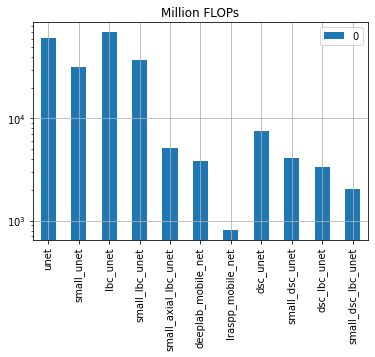

In [10]:
ax = pd.DataFrame.from_dict(model_flop_dict, orient='index').plot.bar(title='Million FLOPs', logy=True)
ax.grid();

In [11]:
pd.DataFrame.from_dict(model_flop_dict, orient='index')

,0
unet,61509.353472
small_unet,31868.583936
lbc_unet,69627.228160
small_lbc_unet,36912.676864
small_axial_lbc_unet,5170.428960
deeplab_mobile_net,3822.231360
lraspp_mobile_net,811.159616
dsc_unet,7562.827776
small_dsc_unet,4142.028800
dsc_lbc_unet,3334.696960


### Run Time

In [ ]:
cuda_dict = load_json_metrics(f'/home/dsola/repos/PGA-Net/src/train/model_profile_cuda_v3.json')
cpu_dict = load_json_metrics(f'/home/dsola/repos/PGA-Net/src/train/model_profile_cpu_v3.json')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(cuda_dict, orient='index').plot.bar(ax=axs[0], title='Train 3 Epochs on GPU')
pd.DataFrame.from_dict(cpu_dict, orient='index').plot.bar(ax=axs[1], title='Train 3 Epochs on CPU')
axs[0].grid()
axs[1].grid();

In [4]:
def net_time_test(net, times, input_, mobile=False):
    backprop_duration = 0
    inference_duration = 0
    for i in range(times):
        if mobile:
            inference_start = time()
            out = net(input_)['out']
            inference_end = time()
        else:
            inference_start = time()
            out = net(input_)
            inference_end = time()
        backprop_start = time()
        out.backward(gradient=torch.randn(2, 3, 256, 256).to(device=device))
        backprop_end = time()
        backprop_duration += backprop_end - backprop_start
        inference_duration += inference_end - inference_start
    return backprop_duration, inference_duration

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


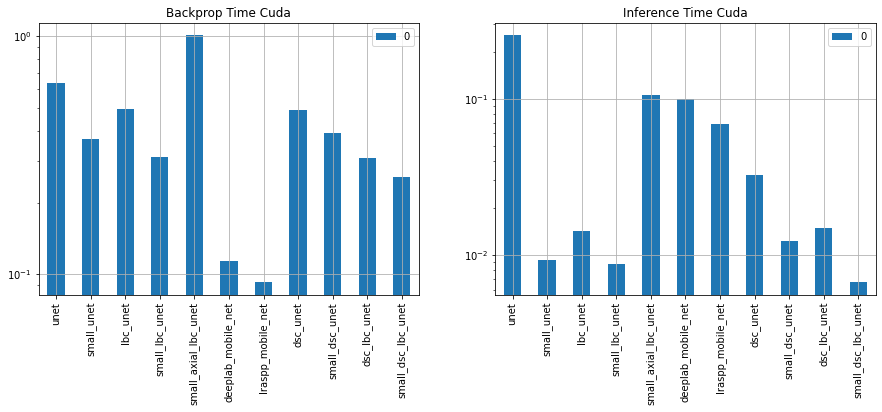

In [5]:
device = 'cuda'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=False)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time Cuda', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time Cuda', logy=True)
axs[0].grid()
axs[1].grid();

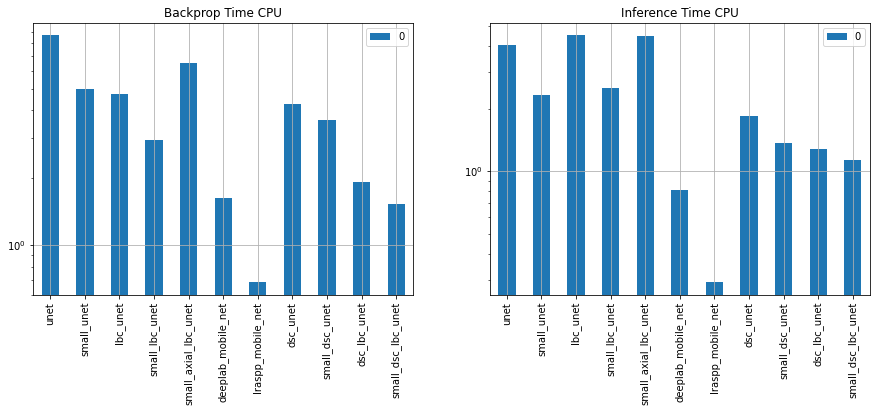

In [6]:
device = 'cpu'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time CPU', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time CPU', logy=True)
axs[0].grid()
axs[1].grid();

In [5]:
from torchvision import models
from torchsummary import summary
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large

In [4]:
summary(DSCSmallUNetLBP(3, 3).to('cuda'), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 256, 256]               6
        DSCConvLBP-2          [-1, 3, 256, 256]              27
            Conv2d-3         [-1, 64, 256, 256]             256
DSCDSCBlockLBPUNet-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
       BatchNorm2d-6         [-1, 64, 128, 128]             128
        DSCConvLBP-7         [-1, 64, 128, 128]             576
            Conv2d-8        [-1, 128, 128, 128]           8,320
DSCDSCBlockLBPUNet-9        [-1, 128, 128, 128]               0
       DSCDownLBP-10        [-1, 128, 128, 128]               0
        MaxPool2d-11          [-1, 128, 64, 64]               0
      BatchNorm2d-12          [-1, 128, 64, 64]             256
       DSCConvLBP-13          [-1, 128, 64, 64]           1,152
           Conv2d-14          [-1, 128,

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
summary(dsc_lbc_unet_model.to('cuda'), (3, 320, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 320, 320]               6
        DSCConvLBP-2          [-1, 3, 320, 320]              27
            Conv2d-3         [-1, 64, 320, 320]             256
DSCDSCBlockLBPUNet-4         [-1, 64, 320, 320]               0
         MaxPool2d-5         [-1, 64, 160, 160]               0
       BatchNorm2d-6         [-1, 64, 160, 160]             128
        DSCConvLBP-7         [-1, 64, 160, 160]             576
            Conv2d-8        [-1, 128, 160, 160]           8,320
DSCDSCBlockLBPUNet-9        [-1, 128, 160, 160]               0
       DSCDownLBP-10        [-1, 128, 160, 160]               0
        MaxPool2d-11          [-1, 128, 80, 80]               0
      BatchNorm2d-12          [-1, 128, 80, 80]             256
       DSCConvLBP-13          [-1, 128, 80, 80]           1,152
           Conv2d-14          [-1, 256,

In [3]:
deeplab_mobile_net_model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 